In [1]:
import gzip
import json
from Bio import SeqIO

with gzip.open("res/go.json.gz") as f:
    ontology = json.load(f)

parents = {}  # { term : list_of_parent_terms }
for edge in ontology["graphs"][0]["edges"]:
    # select only is_a edges
    if edge["pred"] == "is_a":
        parents.setdefault(edge["sub"].split("_")[1], []).append(edge["obj"].split("_")[1])

nodes = []  # list of terms
labels = {}  # { term : definition }
for node in ontology["graphs"][0]["nodes"]:
    # exclude obsolete terms
    if "GO_" in node["id"] and "deprecated" not in node["meta"]:
        nodes.append(node["id"].split("_")[1])
        labels[node["id"].split("_")[1]] = node["lbl"]

# Build an ancestors dictionary
ancestors = {}  # { term : list_of_ancestor_terms }
for node in nodes:
    node_ancestors = []
    node_parents = parents.get(node)
    # Loop parent levels until no more parents
    while node_parents:
        node_ancestors.extend(node_parents)
        # Get the parents of current parents (1 level up)
        node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
    ancestors[node] = node_ancestors


# *** Build a dictionary for the children (similar to the ancestors one) efficiently
children = {}  # { node : list_of_children }, leaf terms are not keys
for node in ancestors:
    for ancestor in ancestors[node]:
        children.setdefault(ancestor, set()).add(node)

In [2]:
def get_dataset(path):
    dataset = []
    with open(path, 'r') as f:
        for line in f:
            dataset.append(line[:-1])
    return dataset

In [3]:
def gen_block(f):
    """
    Parse and split the input.
    The input must be sorted by target name, second column.

    UniProtKB       A0A024R1R8      hCG_2014768             GO:0002181      PMID:21873635   IBA     PANTHER:PTN002008372|SGD:S000007246     P       HCG2014768, isoform CRA_a       hCG_2014768     protein taxon:9606      20171102        GO_Central
    UniProtKB       A0A024RBG1      NUDT4B          GO:0003723      GO_REF:0000037  IEA     UniProtKB-KW:KW-0694    F       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20191109        UniProt
    UniProtKB       A0A024RBG1      NUDT4B          GO:0005829      GO_REF:0000052  IDA             C       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20161204        HPA
    """
    name, old_name = None, None
    chunk = []
    for line in f:
        line = line.decode()
        if line and line[0] != "!":
            _, name, _, _, term, _, ec, _, namespace, protein_name = line.split("\t")[:10]
            term = term[3:]  # remove "GO:" from the term ID
            if name != old_name and old_name:
                yield old_name, set(chunk)  # return a set as there can be repetitions, i.e. the same term with different evidence codes
                chunk = []
            old_name = name
            chunk.append(term)
    # Last line
    if old_name:
        yield old_name, set(chunk)

In [4]:
def GO_counts(path, dataset=None):
    if path:
        dataset = get_dataset(path)
    term_counts = {}
    with gzip.open("res/goa_human.gaf.gz") as f:
        for acc, annotations in gen_block(f):
            if acc in dataset: # if the protein is in the dataset passed to the function
                for term in annotations:
                    term_counts.setdefault(term, 0)
                    term_counts[term] += 1
    return term_counts

In [5]:
fasta_sequences = SeqIO.parse(open('Swiss_Human/Swiss_human.fasta'),'fasta')
human_proteins_swiss = []
for fasta in fasta_sequences:
    name = fasta.id
    proteins = name.split("|")[1]
    human_proteins_swiss.append(proteins)
    
    
dataset_files = ["datasets/original.txt", "datasets/pdb.txt", "datasets/string.txt"]
go_terms_counter_dataset: dict = GO_counts(dataset_files[0])
num_go_dataset = sum(go_terms_counter_dataset.values())

go_terms_counter_human = GO_counts(None, human_proteins_swiss)
num_go_human = sum(go_terms_counter_human.values())

In [6]:
key_intersection = set(go_terms_counter_dataset.keys()).intersection(go_terms_counter_human.keys())


In [7]:
# Measure enrichment performing a Fisher’s exact test (hypergeometric test).

from scipy.stats import fisher_exact

def p_value(go_terms_counter_dataset, num_go_dataset, go_terms_counter_human, num_go_human):
    p_values = {}
    for term, n_term in go_terms_counter_dataset.items():
        human_num = go_terms_counter_human[term]
        not_dataset = num_go_dataset - n_term
        not_human = num_go_human - human_num
        p_value = fisher_exact([[n_term, human_num],[not_dataset, not_human]])[1]
        p_values.setdefault(term, p_value)
    return p_values

In [8]:
go_p_values = p_value(go_terms_counter_dataset, num_go_dataset, go_terms_counter_human, num_go_human)
go_p_values = {k: v for k, v in sorted(go_p_values.items(), key=lambda item: item[1], reverse=False)}
go_p_values = dict(filter(lambda v: v[1] < 0.05, go_p_values.items()))

In [9]:
# *** Calculate the minimum depth (distance from the root) of each term
def calc_depth():
    roots = set(nodes) - set(parents.keys())
    depth = {}  # { term : min_depth }
    for node in nodes:
        c = 0  # Depth level
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            if roots.intersection(set(node_parents)):  # break the loop if the root is among parents
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth

depths = calc_depth()

In [10]:
# Take into consideration the hierarchical structure of the ontologies and report only most enriched branches, i.e. high level terms.

import numpy as np
for key in go_p_values.keys():
    go_p_values[key] = (go_p_values[key], depths[key])

mean = np.mean([v[1] for v in go_p_values.values()])

go_p_values = dict(filter(lambda v: v[1][1] <= 5, go_p_values.items()))

In [15]:
go_labeled_enriched = {}
for k, v in go_p_values.items():
    go_labeled_enriched.setdefault(labels[k], int(np.log(1 / v[0])))

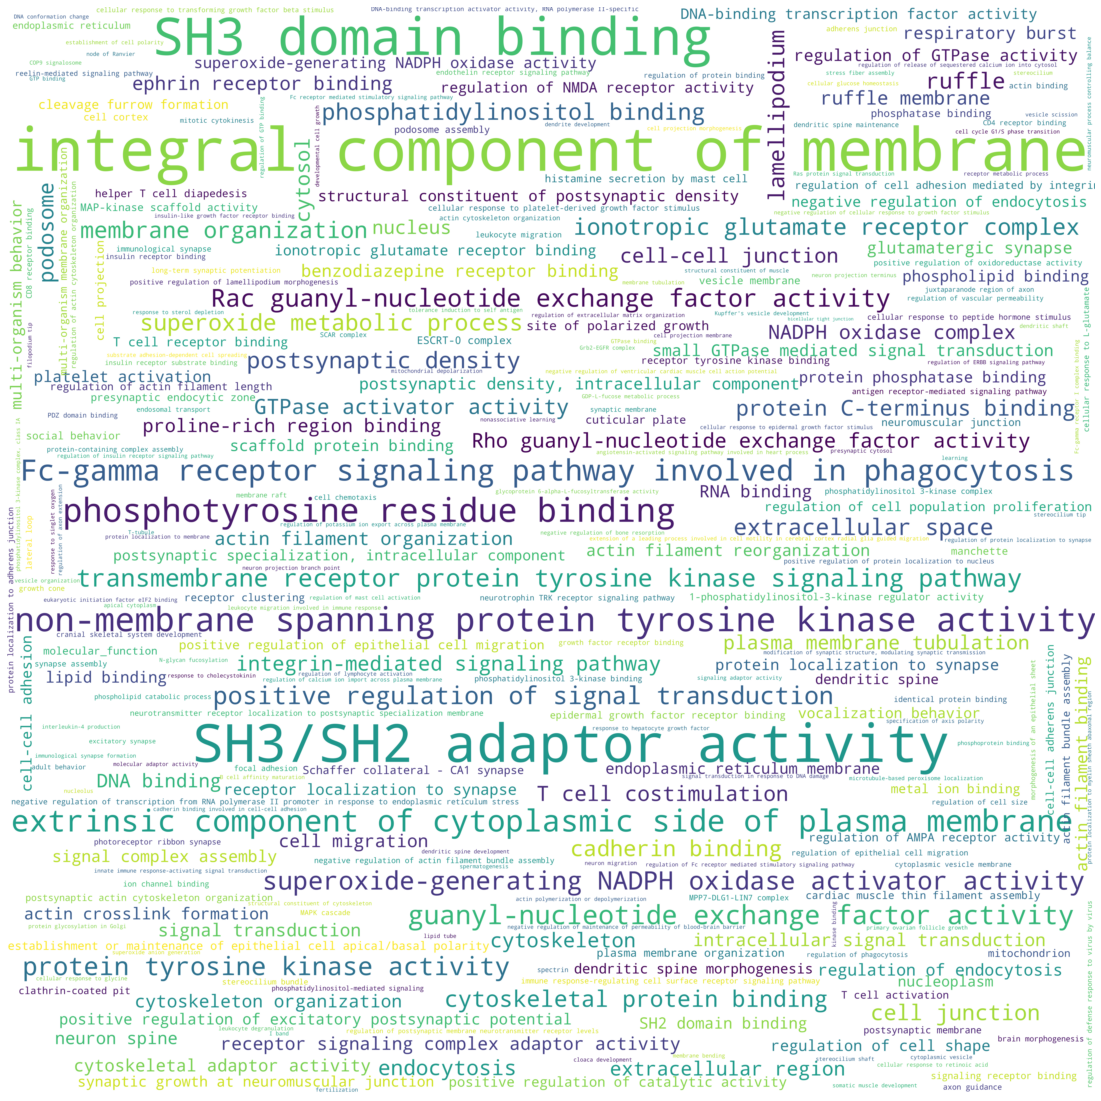

In [17]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=200, max_words=302, width=3000, height=3000, background_color="white", scale=4)
wordcloud.generate_from_frequencies(go_labeled_enriched)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('plot/wordcloud_original.pdf')
plt.axis("off")
plt.close()